In [ ]:
# Install a pip comtradeapicall package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install comtradeapicall

In [ ]:
# Install a pip pandas package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas

In [ ]:
# Install a pip matplotlib package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install matplotlib

In [ ]:
# Install a pip scipy package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scipy

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import comtradeapicall

In [6]:
subscription_key = '<YOUR KEY>' # comtrade api subscription key (from comtradedeveloper.un.org)
directory = '<OUTPUT DIR>'  # output directory for downloaded files

In [7]:
# Call get tariffline data API to a data frame, max to 250K records, free/premium subscription key required
# This example: imports of the assigned commodity_code (below) so that we can calculate the global unit value ($/kg)

In [8]:
Commodity_code = '3006' #pharmaceutical goods
Commodity_code = '1006' #rice
Commodity_code = '6309' #secondhand/ worn clothing
Commodity_code = '7108' #non-monetary gold
Commodity_code = '9201' #piano
Commodity_code = '2709' #crude oil
Commodity_code = '0901' #coffee

In [9]:
# create an Empty DataFrame object
panDForig = pd.DataFrame()
# A list of periods (this is for monthly sets), this is to optimize the API calls and avoid timeout
period_start = '2019-01-01'
period_end = '2022-12-01'
periods = pd.date_range(period_start,period_end,
              freq='MS').strftime("%Y%m").tolist()

In [10]:
#get tariffline import data for assigned commodity_code for several periods 
#Tips: query may time out if too many periods are selected, and it's better to split and loop the queries
#    : if description is not required, set includeDesc=False
for period in periods:
    staging_df = comtradeapicall.getTarifflineData(subscription_key, typeCode='C', freqCode='M', clCode='HS',
                                             period=period,
                                             reporterCode=None, cmdCode=Commodity_code, flowCode='M',
                                             partnerCode=None, partner2Code=None, customsCode=None, motCode=None, maxRecords=None,
                                             format_output='JSON',
                                             countOnly=None, includeDesc=True)
    panDForig = pd.concat([panDForig, staging_df])

In [11]:
#check number of records
print('Final row count is:', len(panDForig))

Final row count is: 317012


In [12]:
#convert period to string for better viz
panDForig['period'] = panDForig['period'].astype('string')
panDForig['motCode'] = panDForig['motCode'].astype('string')
print(panDForig.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317012 entries, 0 to 149
Data columns (total 34 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   typeCode            317012 non-null  object 
 1   freqCode            317012 non-null  object 
 2   refPeriodId         317012 non-null  int64  
 3   period              317012 non-null  string 
 4   reporterCode        317012 non-null  int64  
 5   reporterDesc        317012 non-null  object 
 6   reporterISO         317012 non-null  object 
 7   flowCode            317012 non-null  object 
 8   flowDesc            317012 non-null  object 
 9   partnerCode         317012 non-null  int64  
 10  partnerDesc         317012 non-null  object 
 11  partnerISO          316826 non-null  object 
 12  partner2Code        317012 non-null  int64  
 13  partner2Desc        317012 non-null  object 
 14  partner2ISO         316929 non-null  object 
 15  classificationCode  317012 non-null  

In [13]:
 #show some records
panDForig.head()

,typeCode,freqCode,refPeriodId,period,reporterCode,reporterDesc,reporterISO,flowCode,flowDesc,partnerCode,...,qtyUnitAbbr,qty,altQtyUnitCode,altQtyUnitAbbr,altQty,netWgt,grossWgt,cifvalue,fobvalue,primaryValue
0,C,M,20190101,201901,31,Azerbaijan,AZE,M,Import,76,...,N/A,0.0,-1,N/A,0.0,295.0,0.0,1677.41,0.0,1677.41
1,C,M,20190101,201901,31,Azerbaijan,AZE,M,Import,170,...,N/A,0.0,-1,N/A,0.0,700.0,0.0,3375.75,0.0,3375.75
2,C,M,20190101,201901,31,Azerbaijan,AZE,M,Import,188,...,N/A,0.0,-1,N/A,0.0,207.0,0.0,1269.18,0.0,1269.18
3,C,M,20190101,201901,31,Azerbaijan,AZE,M,Import,222,...,N/A,0.0,-1,N/A,0.0,69.0,0.0,556.62,0.0,556.62
4,C,M,20190101,201901,31,Azerbaijan,AZE,M,Import,231,...,N/A,0.0,-1,N/A,0.0,60.0,0.0,433.83,0.0,433.83


In [14]:
#some descriptive stats
panDForig[['primaryValue','netWgt']].describe()

,primaryValue,netWgt
count,3.170120e+05,3.170120e+05
mean,2.874870e+05,7.380284e+04
std,2.134587e+06,1.108143e+06
min,0.000000e+00,0.000000e+00
25%,1.147359e+02,3.000000e+00
50%,3.665903e+03,2.650000e+02
75%,5.715142e+04,7.860000e+03
max,1.553074e+08,4.317820e+08


In [15]:
#add new column UVnetWgt = primaryValue/netWgt
panDForig['UVnetWgt'] = panDForig.primaryValue / panDForig.netWgt

In [16]:
#remove UVnetWgt NaN,zero, inf, but and keeping only mode of transport and period
panDF = panDForig[["motDesc","period","UVnetWgt"]]
panDF = panDF[panDF.notnull()].query('UVnetWgt>0')
panDF = panDF[panDF.notnull()].query('UVnetWgt<999999999999999')
panDF.describe()

,UVnetWgt
count,2.609790e+05
mean,1.763526e+02
std,1.489115e+04
min,1.412928e-03
25%,4.301726e+00
50%,7.858006e+00
75%,1.556242e+01
max,5.745007e+06


Text(0.5, 1.0, 'Unit Value Distribution')

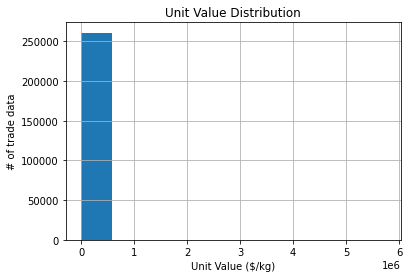

In [17]:
 # plot the Unit Value histogram
panDF.hist("UVnetWgt");
plt.xlabel('Unit Value ($/kg)')
plt.ylabel('# of trade data')
plt.title('Unit Value Distribution')

Text(0.5, 1.0, 'Unit Value Distribution')

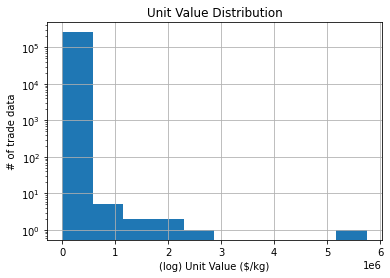

In [18]:
# plot the Unit Value histogram - in log scale (more suited for trade data with long distribution tail)
panDF.hist("UVnetWgt", log=True);
plt.xlabel('(log) Unit Value ($/kg)')
plt.ylabel('# of trade data')
plt.title('Unit Value Distribution')

In [19]:
#add log UVnetWgtLog
panDF.loc[:,'UVnetWgtLog'] = np.log(panDF['UVnetWgt'])
panDF.describe()

,UVnetWgt,UVnetWgtLog
count,2.609790e+05,260979.000000
mean,1.763526e+02,2.138797
std,1.489115e+04,1.122537
min,1.412928e-03,-6.562091
25%,4.301726e+00,1.459016
50%,7.858006e+00,2.061533
75%,1.556242e+01,2.744859
max,5.745007e+06,15.563842


In [20]:
#remove outliers based on zcores (if more than 3 standard deviation) on the log Unit Value
from scipy.stats import zscore
#calculate z-scores of `df`
z_scores = zscore(panDF['UVnetWgtLog'], axis=0)
#print(z_scores)
abs_z_scores = np.abs(z_scores)
#print(abs_z_scores)
filtered_entries = (abs_z_scores < 3)
#print(filtered_entries)
new_panDF = panDF[filtered_entries]

In [21]:
 #descriptive statistics after outliers removal
new_panDF.describe()

,UVnetWgt,UVnetWgtLog
count,258076.000000,258076.000000
mean,14.040873,2.116755
std,20.184583,0.981621
min,0.292951,-1.227750
25%,4.314691,1.462026
50%,7.825628,2.057404
75%,15.336877,2.730260
max,246.224681,5.506244


array([[<AxesSubplot: title={'center': 'UVnetWgt'}>,
        <AxesSubplot: title={'center': 'UVnetWgtLog'}>]], dtype=object)

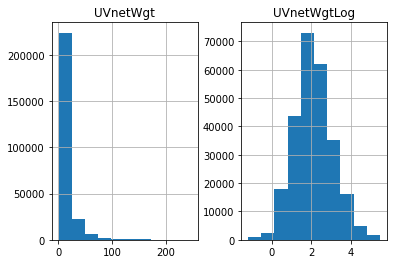

In [22]:
#histogram statistics after outliers removal
new_panDF.hist(column=['UVnetWgt','UVnetWgtLog'])

<AxesSubplot: xlabel='period'>

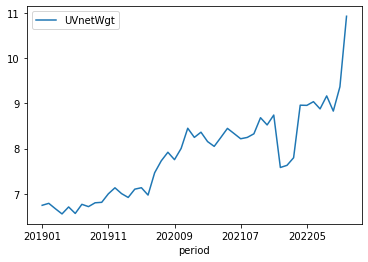

In [23]:
#plot median in timeseries after outliers removal
new_panDF[['period','UVnetWgt']].groupby("period").median().plot()

<AxesSubplot: xlabel='motDesc'>

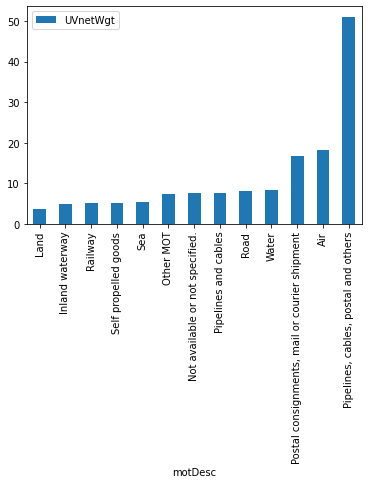

In [25]:
#plot median by mode of transport after outliers removal
new_panDF[['motDesc','UVnetWgt']].groupby("motDesc").median().sort_values(by='UVnetWgt').plot.bar(y='UVnetWgt', rot=90)

In [26]:
#some extra analysis  - descriptive statstiscs by period
new_panDF[['period','UVnetWgt']].groupby("period").describe()

UVnetWgt                                                       \
          count       mean        std       min       25%        50%   
period                                                                 
201901   5311.0  11.905347  16.674747  0.311515  3.423596   6.745966   
201902   5157.0  12.202079  18.438293  0.311602  3.418365   6.789558   
201903   5597.0  11.812777  15.889995  0.298700  3.443513   6.669849   
201904   5369.0  11.779885  16.649138  0.296212  3.359877   6.555488   
201905   5694.0  11.947720  17.057678  0.305696  3.350280   6.709686   
201906   5359.0  11.836543  16.614299  0.292951  3.356168   6.566066   
201907   5819.0  12.191402  17.834847  0.297433  3.383162   6.767513   
201908   5690.0  12.326743  18.256831  0.307842  3.398652   6.716867   
201909   5714.0  12.288810  17.495857  0.302741  3.497334   6.801586   
201910   5843.0  12.443645  17.782956  0.323729  3.474606   6.811947   
201911   5697.0  12.658395  18.596212  0.297970  3.498140   6.999563   
201912   5743.0  13.111265  18.541617  0.305434  3.641157   7.133333   
202001   5480.0  13.002232  19.599188  0.301429  3.582522   7.004370   
202002   5362.0  12.598604  18.909718  0.300685  3.593783   6.919611   
202003   5047.0  13.009509  19.739415  0.310634  3.777773   7.103196   
202004   4518.0  12.902292  18.279417  0.297822  3.776265   7.135075   
202005   4683.0  13.060329  19.613745  0.336002  3.731983   6.972085   
202006   5085.0  13.706745  19.332285  0.294843  4.040844   7.466051   
202007   5477.0  13.888019  19.911159  0.296671  4.011662   7.729942   
202008   5270.0  14.039307  20.135844  0.296216  4.189113   7.919513   
202009   5561.0  13.997132  20.970273  0.300000  4.265152   7.755777   
202010   5684.0  13.849611  19.254436  0.297433  4.177228   8.003101   
202011   5396.0  14.964765  21.206818  0.314000  4.474761   8.450469   
202012   5780.0  14.572610  20.095736  0.300000  4.441299   8.248408   
202101   5378.0  15.127194  21.006827  0.308354  4.284632   8.363322   
202102   5532.0  14.829097  21.034814  0.306565  4.262905   8.155251   
202103   6144.0  14.743947  21.703994  0.306790  4.263925   8.049502   
202104   5921.0  15.231964  21.989209  0.303906  4.435498   8.246112   
202105   5826.0  15.233444  21.601215  0.313213  4.520128   8.447599   
202106   5912.0  15.039506  21.313040  0.328502  4.594475   8.333793   
202107   5902.0  15.848476  23.920978  0.321429  4.582088   8.218017   
202108   5959.0  15.708330  23.374185  0.325616  4.689354   8.247665   
202109   6040.0  15.741680  23.498066  0.300000  4.807740   8.327670   
202110   6087.0  16.207054  23.505964  0.309576  5.003836   8.683673   
202111   6194.0  15.871981  22.501968  0.295864  4.964053   8.524045   
202112   6270.0  16.045733  23.251839  0.300000  5.231357   8.742474   
202201   6290.0  14.220259  21.623047  0.300719  4.402695   7.582485   
202202   6493.0  14.203314  20.704236  0.298358  4.536760   7.629829   
202203   6897.0  14.374753  21.004307  0.296182  4.683057   7.798031   
202204   5771.0  15.098895  19.374830  0.333333  5.680458   8.960781   
202205   5913.0  14.828840  19.243348  0.325515  5.711560   8.956675   
202206   5936.0  14.958052  19.196568  0.295097  5.764225   9.038549   
202207   5200.0  14.366596  18.930841  0.333333  5.832042   8.878771   
202208   5533.0  15.382703  20.530023  0.342448  5.914722   9.165497   
202209   4966.0  15.456241  21.738578  0.330126  5.884567   8.830290   
202210   3447.0  16.000095  21.056678  0.342887  6.068292   9.368265   
202211    129.0  17.332230  24.407213  0.320865  6.366163  10.928169   

                               
              75%         max  
period                         
201901  13.471138  235.000000  
201902  13.359605  243.788295  
201903  13.567797  219.380000  
201904  13.152726  218.764706  
201905  13.170130  221.322394  
201906  13.219498  218.661028  
201907  13.818454  237.800000  
201908  13.704874  243.293563  
201909  13.716738  234.383070  
201910  14.111432  242

In [27]:
#some extra analysis - descriptive statstiscs by motOfTransport (air, water,land)
new_panDF[['motDesc','UVnetWgt']].groupby("motDesc").describe()

UVnetWgt                        \
                                                  count       mean        std   
motDesc                                                                         
Air                                             17420.0  30.434085  35.436775   
Inland waterway                                   295.0   5.729476   4.733010   
Land                                             2698.0   6.366309   6.962589   
Not available or not specified.                117571.0  13.963836  20.811917   
Other MOT                                       16443.0  11.437754  14.038185   
Pipelines and cables                               23.0   7.176022   2.363911   
Pipelines, cables, postal and others                1.0  51.070000        NaN   
Postal consignments, mail or courier shipment    8827.0  21.460041  18.836260   
Railway                                          1448.0   7.634682   9.409661   
Road                                            55650.0  12.356988  14.881630   
Sea                                             35520.0   9.303063  13.434043   
Self propelled goods                               22.0   8.914354  14.007930   
Water                                            2158.0  11.939171  14.989337   

                                                                     \
                                                     min        25%   
motDesc                                                               
Air                                             0.296937   8.258977   
Inland waterway                                 1.650458   3.755543   
Land                                            0.812903   2.037844   
Not available or not specified.                 0.295097   4.314088   
Other MOT                                       0.299403   5.137083   
Pipelines and cables                            2.598995   5.884215   
Pipelines, cables, postal and others           51.070000  51.070000   
Postal consignments, mail or courier shipment   0.319067  12.290057   
Railway                                         0.300719   2.997251   
Road                                            0.297433   4.760681   
Sea                                             0.292951   2.852460   
Self propelled goods                            0.500000   4.822421   
Water                                           0.322502   3.663267   

                                                                     \
                                                     50%        75%   
motDesc                                                               
Air                                            18.198350  38.965325   
Inland waterway                                 4.929970   6.269998   
Land                                            3.714601   7.550971   
Not available or not specified.                 7.528935  14.577410   
Other MOT                                       7.407740  13.341786   
Pipelines and cables                            7.651920   8.628816   
Pipelines, cables, postal and others           51.070000  51.070000   
Postal consignments, mail or courier shipment  16.814711  24.175053   
Railway                                         5.186583   8.616173   
Road                                            8.101643  14.323479   
Sea                                             5.270819  10.467124   
Self propelled goods                            5.240631   5.743018   
Water                                           8.300098  14.141250   

                                                           
                                                      max  
motDesc                                                    
Air                                            246.089103  
Inland waterway                                 44.186228  
Land                                            90.609164  
Not available or not specified.                246.224681  
Other MOT                                      243.78829